### Sparse Attention Operator
This is an example of how to create and tune a sparse attention operator.

In [1]:
import torch
import sparta
import matplotlib.pyplot as plt

device = 'cuda:0'

First, determine the shape: batch size, source sequence length, target sequence length and embed dimension.
- Input query shape: `(batch_size, tgt_seq_len, embed_dim)`
- Input key shape: `(batch_size, src_seq_len, embed_dim)`
- Input value shape: `(batch_size, src_seq_len, embed_dim)`
- Output shape: `(batch_size, tgt_seq_len, embed_dim)`

In [2]:
batch_size, src_seq_len, tgt_seq_len, embed_dim = 1, 3072, 4096, 768

Then generate a mask with block size $32\times32$, in which 80% of blocks are empty. 

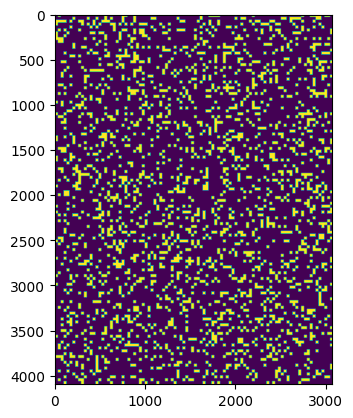

In [3]:
mask = sparta.testing.block_mask((tgt_seq_len, src_seq_len), block=(32, 32), sparsity=0.8, device=device)
plt.imshow(mask.cpu().numpy())

Create a ```sparta.nn.SparseAttention``` operator using the mask.

Next, tune the sparse operator using sample inputs and gradients. This time we set `backward_weight=1` to activate backward kernels in tuning. This step may take 15 minutes.

In [4]:
query = torch.rand((batch_size, tgt_seq_len, embed_dim), device=device)
key = torch.rand((batch_size, src_seq_len, embed_dim), device=device)
value = torch.rand((batch_size, src_seq_len, embed_dim), device=device)
grad = torch.rand((batch_size, tgt_seq_len, embed_dim), device=device)
sparse_attention = sparta.nn.SparseAttention(mask=mask)

# The tune() function will find the best config,
# build the sparse operator and return the best config.
# If you have already tuned once and saved the best config,
# you can skip the tune() step and build the operator directly.
best_config = sparta.nn.tune(
    sparse_attention,
    sample_inputs=[query, key, value],
    sample_grads=[grad],
    backward_weight=1,
    algo='rand',
    max_trials=30,
)

print("before serialization", best_config)
import jsonpickle

with open("sparse_attention_best_config.json", "w") as f:
    f.write(jsonpickle.dumps(best_config))
best_config = jsonpickle.loads(
    open("sparse_attention_best_config.json", "r").read()
)
print("after serialization", best_config)

/home/kwu/anaconda3/envs/dev_cupy_graph/lib/python3.11/site-packages/sparta/tesa/block_compressed.py:108: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  return torch.sparse_csr_tensor(
STAGE:2023-12-21 22:07:54 1609485:1609485 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2023-12-21 22:07:54 1609485:1609485 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2023-12-21 22:07:54 1609485:1609485 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
STAGE:2023-12-21 22:07:55 1609485:1609485 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2023-12-21 22:07:55 1609485:1609485 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2023-12-21 22:07:55 1609485:1609485 ActivityProfilerControlle

before serialization {'root': {'qk/forward:C': {'_impl': 'sparta', 'BLOCK_SIZE_M_VALUE': 32, 'BLOCK_SIZE_K_VALUE': 16, 'BLOCK_SIZE_N_VALUE': 32}, 'qk/backward:A': {'_impl': 'sparta', 'BLOCK_SIZE_M_VALUE': 32, 'BLOCK_SIZE_K_VALUE': 32, 'BLOCK_SIZE_N_VALUE': 32}, 'qk/backward:B': {'_impl': 'sparta', 'BLOCK_SIZE_M_VALUE': 32, 'BLOCK_SIZE_K_VALUE': 32, 'BLOCK_SIZE_N_VALUE': 32}, 'sm/forward:y': {'_impl': 'sparta', 'BLOCK_SIZE_H_VALUE': 32, 'BLOCK_SIZE_W_VALUE': 32, 'ROW_TILE_VALUE': 4}, 'sm/backward:x': {'_impl': 'sparta', 'BLOCK_SIZE_H_VALUE': 32, 'BLOCK_SIZE_W_VALUE': 32, 'ROW_TILE_VALUE': 1}, 'out/forward:C': {'_impl': 'sparta', 'BLOCK_SIZE_M_VALUE': 32, 'BLOCK_SIZE_K_VALUE': 32, 'BLOCK_SIZE_N_VALUE': 32}, 'out/backward:A': {'_impl': 'sparta', 'BLOCK_SIZE_M_VALUE': 32, 'BLOCK_SIZE_K_VALUE': 16, 'BLOCK_SIZE_N_VALUE': 32}, 'out/backward:B': {'_impl': 'sparta', 'BLOCK_SIZE_M_VALUE': 32, 'BLOCK_SIZE_K_VALUE': 32, 'BLOCK_SIZE_N_VALUE': 64}}}
after serialization {'root': {'qk/forward:C': {'_i

Check whether the sparse operator works correctly.

We provide `sparta.testing.sparse_multi_head_attention_reference()` function to calculate masked attention using dense method.

In [5]:
def forward_backward(func):
    out = func(query, key, value)
    out.backward(grad)
    return out, query.grad, key.grad, value.grad

query.requires_grad = True
key.requires_grad = True
value.requires_grad = True

def dense_attention(query, key, value):
    return sparta.testing.sparse_multi_head_attention_reference(query, key, value, mask)

for sparse_out, dense_out in zip(forward_backward(dense_attention), forward_backward(sparse_attention)):
    torch.testing.assert_close(sparse_out, dense_out)

The sparse softmax operator is ready to use. Let's compare it with the dense function.

In [6]:
dense_latency = sparta.testing.profile(forward_backward, inputs=[dense_attention], num_warmups=100, num_iters=100)
print(f'Dense attention forward + backward latency: {dense_latency} ms')
sparse_latency = sparta.testing.profile(forward_backward, inputs=[sparse_attention], num_warmups=100, num_iters=100)
print(f'Sparse attention forward + backward latency: {sparse_latency} ms')

Dense attention forward + backward latency: 8.186421508789062 ms
Sparse attention forward + backward latency: 2.8296240234375 ms
